In [3]:
######################################
# DEPENDENCIES
######################################
import os
import math
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'torch'

## The Data
From the __[NASA Exoplanet archive](https://exoplanetarchive.ipac.caltech.edu/index.html)__, we have retrieved 3 data tables:
 - A table storing information relating to each exoplanet & its planetary system
 - A table storing information relating to the transit spectroscopy of exoplanet
 - A table storing information relating to the emission spectroscopy of exoplanet


In [ ]:

#Raw Data Tables
systems_df = pd.read_csv('data/PS_2021.12.14_19.44.55.csv', sep=',', low_memory=False)

transitspec_df = pd.read_csv('data/transitspec_2021.10.21_17.04.26.csv', sep=',', low_memory=False)

emispec_df = pd.read_csv('data/emissionspec_2021.10.22_13.36.00.csv', sep=',', low_memory=False)

## Discovery Method
The most important and generalized information is stored in the "Planetary Systems" database, which we will be calling _systems_df_. This is general information about the discovery of the planets, what system they are from, and the most pertinant information about the exoplanet and system.

Notice that in this table, we have included the 'discovery method' column, as this is relevant to the interpretation of all other features. Particularly, notice that there is associated with the plantary mass a 'provenance', which indicates wether or not a planet's mass is given as a "True Mass" or as a lower bound on planetary mass, depending on the discovery method. 

We will stratify the data by its method of discovery, so that meaningful comparisons can be made between rows. One of the most common and successful discovery methods is the transit method, which refers to observations of a planet which passes directly in between it's host star and the viewer, altering the observed light effects:

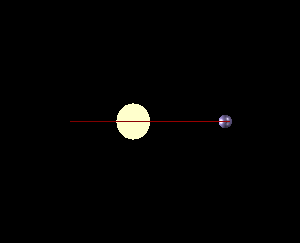

(image in public domain)

We will start by working on the data obtained by this method, and then move on to other popular methods such as Radial Velocity, Direct Imaging, or Microlensing. 



## General Purpose
- Create a program which can interpret a mixture of planetary and stellar data to classify planets into the categories of habitable and not habitable, based on pre-existing definitions garnered from what has been studies about life on Earth.
(The obvious problem with this model is that we know so little about life elsewhere in the cosmos.)

## Habitability Classification
In the preprocessing stage of our investigation, we shall determine the planets which fall within the following bounds to be "habitable." Planets which fail to meet any of these parameters will be considered not habitable.

Stellar Characteristics:
- Stellar Mass: 0.4 to 1.4 times the Sun’s mass 
- Types of habitable stars
    - Late F, G, to mid
- Temperature: Between 3000 and 7000 K
- Using Luminosity to determine habitable zone 
- (Actually, use absolute luminosity)
    - ri = √Lstar/1.1 (inner boundary of habitable zone)
    - r0 = √Lstar/0.53 (outer boundary of habitable zone)
    - link: https://www.planetarybiology.com/calculating_habitable_zone.html
- Than, based on these bounds, if orbit semi-major axis falls outside of these zones, not habitable
- Stellar Age: Stars formed between 11 and 3.8 billion years ago
    - Thus, valid age range lies between 3.8 and 11 billion years old
   

- Stellar Metallicity
    - Strongly affects the duration of the habitable zone, and the distance from the host star where duration is maximized 
    - General rule: Stars having significantly high-than-solar metallicity have a much longer duration of habitability at a given distance than do stars of lower-than-solar metallicity. Heavy elements are required for life to emerge, and stars without heavy metal presence were likely formed in the primordial stages of the universe. 
    - For a 1.0 M star (mass of the sun) w/ solar metallicity of 0.017 duration of habitable zone lasts for less than 10 billion years at 1.2 to 2.0 AU from the star
    - Duration is greater than 20 billion years for high-metallicity stars (0.070) at distances 0.7-1.8 AU
    - ~4 Billion years at distances of 1.8-3.3 AU for low-metallicity stars (0.0001)  
    - Paper: https://iopscience.iop.org/article/10.1088/0004-637X/769/1/27/pdf
    - We are already using the above equations to determine our "habitable" zones
    - As such, we will primarily use metallicity to characterize duration.
    - The characterization for metallicities effects depends widely on the other parameters, including stellar age, distance, and semi-major orbital axis. As such, for the purpose of this classification, stars that fall below the metallicity of 0 will be ruled as inhabitable. Any lower of a ratio would result in a lack of heavy elements sufficient to support complex biological structures. 
 


Planetary Characteristics
Orbital Eccentricity (a less certain parameter)
- Habitability model refers to obliquity, spin rate, orbital    eccentricity, and fraction of the surface covered by ocean
- Since so few of the planets have statistics for obliquity (true or projected) eccentricity is veritably useless)
- Equilibrium Temperature (no real known bounds on habitability)
- (HOWEVER, could classification find relationships? Include as features anyways?)

- Planetary Mass:
    - Must be at least 2.7 percent mass of Earth
    - Paper: https://iopscience.iop.org/article/10.3847/1538-4357/ab2bf2
    - Any smaller than 2.7 percent, and the planet will not be able to hold onto its atmosphere and water long enough for life to appear
    - Upper bound on Planetary mass: 5 𝑀⊕ (earth masses)

    

  


In [ ]:
#ASK: what are the MOST ESSENTIAL features?
for col in systems_df.columns:
    print(col)

## Strata

In [ ]:

#To avoid controversy, remove rows with nonzero 'controversial' flag
systems_df = systems_df[systems_df['pl_controv_flag'] == 0]
systems_df.drop(columns = 'pl_controv_flag')

pl_systems_transit = systems_df[systems_df['discoverymethod'] == 'Transit']
print(f"num rows by Transit method: {len(pl_systems_transit)}")
#print(f"% default: {len(pl_systems_transit[pl_systems_transit['default_flag'] == 1])/len(pl_systems_transit)}")
#print(f"% of total default: {len(pl_systems_transit[pl_systems_transit['default_flag'] == 1])/total_default}\n")

pl_systems_radial = systems_df[systems_df['discoverymethod'] == 'Radial Velocity']
print(f"num rows by Radial Velocity method: {len(pl_systems_radial)}")
#print(f"% default: {len(pl_systems_radial[pl_systems_radial['default_flag'] == 1])/len(pl_systems_radial)}")
#print(f"% of total default: {len(pl_systems_radial[pl_systems_radial['default_flag'] == 1])/total_default}\n")

pl_systems_img = systems_df[systems_df['discoverymethod'] == 'Imaging']
print(f"num rows by Direct Imaging method: {len(pl_systems_img)}")
#print(f"% default: {len(pl_systems_img[pl_systems_img['default_flag'] == 1])/len(pl_systems_img)}")
#print(f"% of total default: {len(pl_systems_img[pl_systems_img['default_flag'] == 1])/total_default}\n")

pl_systems_microlens = systems_df[systems_df['discoverymethod'] == 'Microlensing']
print(f"num rows by Microlensing method: {len(pl_systems_microlens)}")
#print(f"% default: {len(pl_systems_microlens[pl_systems_microlens['default_flag'] == 1])/len(pl_systems_microlens)}")
#print(f"% of total default: {len(pl_systems_microlens[pl_systems_microlens['default_flag'] == 1])/total_default}\n")

pl_systems_eclipse = systems_df[systems_df['discoverymethod'] == 'Eclipse Timing Variations']
print(f"num rows by Eclipse Timing method: {len(pl_systems_eclipse)}")
#print(f"% default: {len(pl_systems_eclipse[pl_systems_eclipse['default_flag'] == 1])/len(pl_systems_eclipse)}")
#print(f"% of total default: {len(pl_systems_eclipse[pl_systems_eclipse['default_flag'] == 1])/total_default}\n")



pl_names = systems_df['pl_name']


As we can see from the above calculations, the Transit method is the most common and popular, yet the least reliable, going by the readings which are flagged as 'default' for that particular exoplanet. On the other hand, Radial velocity, though less reliable than Direct Imaging, has a good amount of default readings, and also has a higher amount of features.

In [ ]:
#define our inputs for the rest of the pipeline


#we don't need to look at name or discovery method
X = pl_systems_img.iloc[:, 2:]

#print(X)

## Imputation
Because this dataset contains a significant amount of missing values, we will experiment with imputing the missing values, in order to avoid throwing away whole planet rows.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
#from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor # had the best results with this.
estim = DecisionTreeRegressor(max_features="sqrt", random_state=0)

X.hist(bins=15, color='steelblue', edgecolor='black', linewidth=0.5,
           xlabelsize=5, ylabelsize=8, grid=False)  
plt.tight_layout(rect=(0, 0, 2, 2))   
plt.show()

imp = IterativeImputer(estimator=estim, max_iter=100, n_nearest_features=11, imputation_order='ascending', add_indicator=False)

#imp = SimpleImputer(strategy='mean')
#fit the model
imp.fit(X)
    
#impute missing values
imp_results = imp.transform(X)

X_imp = pd.DataFrame(imp_results, columns=X.columns)

X_imp.hist(bins=15, color='red', edgecolor='black', linewidth=0.5, xlabelsize=5, ylabelsize=8, grid=False)

plt.tight_layout(rect=(0, 0, 2, 2))   
plt.show()
    
#These plots should look as similar as possible


In [ ]:
imp_results

## Creating Training Data (partitioning table based on defined parameters)

In [ ]:
earth_mass = systems_df[(systems_df['pl_bmasse'] > 0.257) & (systems_df['pl_bmasse'] < 5)]
valSun = earth_mass[(earth_mass['st_teff'] > 2300) & (earth_mass['st_teff'] < 7600)]
# the error may be in the habitable zone calculation

# If the semi-major orbital axis takes the planet beyond these zones,
# we will not classify the planet as habitable.

# represents the systems data that has luminosity values

# Stellar mass: 0.4 < x < 1.4 (in Sun masses)
systems_df_4 = new[new['st_mass'] > 0.4]
systems_df_5 = systems_df_4[systems_df_4['st_mass'] < 1.6]

# Luminosity (will be used in the following calculation)
# Stellar luminosity is just 1
#ri = √Lstar/1.1 (inner boundary of habitable zone)
#r0 = √Lstar/0.53 (outer boundary)
systems_inner_bound = systems_df_5['st_logg']/1.1 ** 1/2
systems_outer_bound = systems_df_5['st_logg']/0.53 ** 1/2
# now, we have to ensure that the semi-major orbital axis
# falls within thse parameters to find the "habitable" planets
# orbsmax
# valid_semi_major
valid_orbit = systems_df_5[(systems_df_5['pl_orbsmax'] > systems_inner_bound)&(systems_df_5['pl_orbsmax'] < systems_outer_bound)]
# When it falls between these age ranges

# valid orbit is messed up
# Stellar Age: between 3.8 and 11 billion years old
valid_age = systems_df_5[(systems_df_5['st_age'] > 3.8) & (systems_df_5['st_age'] < 11)]
# stellar metallicity: greater than 0
# the bound that we are accepting as the range of habitability
valmet = valid_age[(valid_age['st_met'] > 0)]

# the largest terrestrial planet in the galaxy has a mass of 17 Earth
# Masses
valid_mass = valmet[(valmet['pl_bmasse'] > 0.25) & (valmet['pl_bmasse'] < 17)]
# reupload the table with only the filled in values, missing values
# must be imputed. So systems_df_3 takes from perfect table
systems_not_habitable = pd.concat([systems,valid_mass]).drop_duplicates(keep=False)

# We then divide these features into training and test data
# We take random subset of positive answers, and we label them
# as x training data

# training data for habitable planets
x_train_habitable = valid_mass.sample(n=(math.ceil(len(valid_mass)*(2/3))))
y_train_habitable = np.ones(len(x_train_habitable))

# training data for uninhabitable planets
x_train_uninhabitable = systems_not_habitable.sample(n=(math.ceil(len(systems_not_habitable) * 2/3)))
y_train_uninhabitable = np.zeros(len(x_train_uninhabitable))

# test data for habitable planets
x_test_habitable = pd.concat([valid_mass, x_train_habitable]).drop_duplicates(keep=False)
y_test_habitable = np.ones(len(x_test_habitable))

# test data for uninhabitable
x_test_uninhabitable = pd.concat([systems_not_habitable,x_train_uninhabitable]).drop_duplicates(keep=False)
y_test_uninhabitable = np.zeros(len(x_test_uninhabitable))





## The Habitable Exoplanets Catalog

There exists, of course, much active and ongoing discourse within the astrobiology community on what is the appropriate severity with which to discriminate when determining the boundaries for the vague class that is "potentially habitable exoplanets". Nevertheless, this is the great question that many are investigating, and the most widely referenced list of these potentially habitable worlds comes from the Planetary Habitability Lab at the University of Puerto Rico Arecibo (https://phl.upr.edu/projects/habitable-exoplanets-catalog), which divides the results into a conservative list of potential exoplanets, and an optimistic list. 

From this, we may divide the data into three classes:
 - [1] Conservatively earth-like
 - [2] Optimistically earth-like
 - [3] Unlikely earth-like
 
The more specific criteria for these classes and some interesting information about each of the planets in classes 1 and 2 can be found at the link above.

In [ ]:


PHE_conservative = ['Teegardens Star b', 'TOI-700 d', 'Kepler-1649 c', 'TRAPPIST-1 d', 'Proxima Cen b',  'K2-72 e', 'GJ, 1061 d', 'GJ 1061 c', 'Ross 128 b', 'GJ 273 b', 'Kepler-269 e', 'TRAPPIST-1 e', 'Kepler-442 b', 'GJ 667 C f', 'Kepler-62 f', 'TRAPPIST-1 f', 'Teegardens Star c', 'Kepler-1229 b', 'Kepler-186 f', 'GJ 667 C e', 'TRAPPIST-1 g']

PHE_optimistic = ['Kepler-452 b', 'Kepler-62 e', 'Kepler-1652 b', 'Wolf 1061 c', 'Kepler-1410 b', 'GJ 667 C c', 'Kepler-1544 b', 'Kepler-283 c', 'Kepler-1638 b', 'Kepler-440 b', 'GJ 443 d', 'Kepler-1653 b', 'GJ 832 c', 'Kepler-705 b', 'K2-332 b', 'Kepler-155 c', 'TOI-2257 b', 'Kepler-443 b', 'Kepler-22 b', 'Kepler-1701 b', 'K2-18 b', 'Kepler-1606 b', 'K2-9 b', 'GJ 180 c', 'GJ 163 c', 'Kepler-1540 b', 'Kepler-174 d', 'HD 40307 g', 'Kepler-296 f', 'HIP 38594 b', 'K2-288 B b', 'HD 216520 c', 'GJ 3293 d', 'LHS 1140 b', 'GJ 229 A c', 'GJ 357 d', 'GJ 682 b', 'GJ 180 d']

for pl in PHE_conservative:
    for row in X:
        

## Earth Similarity Index (ESI)
\<provide some more info>

## Our Solar System

There is actually one datapoint that we can confidently label as 'habitable' and that is our home system of the sun, and our home planet of earth. Once we have discovered the underlying distribution of all other exoplanet systems, this information may be used to create a discrete classification for exoplanets that seem to be in a similar ballpark.

In [ ]:

#extract the stellar features of highest importance from this table
# - Host Star Name (optional)
# - Stellar Mass
# - Stellar Metallicity
# - Stellar Effective temperature
starinfo_df = systems_df[['st_mass', 'st_met', 'st_teff']]

#define these same features for our sun (source: Wikipedia)
SUN_MASS = 1
SUN_MET = 0.0122
SUN_TEFF = 5772

m_sun = np.array([SUN_MASS,
                 SUN_MET,
                 SUN_TEFF])


## Gaussian Mean and Variance

In [ ]:
starinfo_x = starinfo_df.dropna()
#The line above is somewhat problematic due to the erasure of some potentially valid data

starinfo_mean = starinfo_x.mean();

print("mean vector of stellar features:\n {0} \n".format(starinfo_mean))

print("covariance of key stellar features")
cov_X = starinfo_x.cov()
print(cov_X)

print("\ncorrelation of key stellar features")
corr_X = starinfo_x.corr()
print(corr_X)

print(starinfo_x)

In [ ]:
#####################################################
#DEFINE INPUT SPACE
#####################################################

X = starinfo_x.to_numpy()
print (X.shape)
print(X)


In [ ]:
#####################################################

X = starinfo_x.to_numpy()
print (X.shape)
print(X)


In [ ]:
from sklearn.decomposition import KernelPCA, FactorAnalysis

## Kernel PCA
The next step will be to try to use simple generative linear models to obtain insights on the nature of the data. We will start by performing principal component analysis with a selection of various common kernel functions.

In [ ]:
#PCA

kpca = KernelPCA(n_components=2, kernel='linear') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, linear kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ linear kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

kpca = KernelPCA(n_components=2, kernel='poly', degree=3) #increasing degree of poly kernel seems to reduce variance.
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, polynomial kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ cubic kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

kpca = KernelPCA(n_components=2, kernel='rbf') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, rbf kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ rbf kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()


kpca = KernelPCA(n_components=2, kernel='cosine') 
kpca.fit(X);
X_kpca = kpca.transform(X)

print(f"Latent space from PCA, cosine kernel: \n{X_kpca}\n")

plt.title('2d PCA w/ cosine kernel')
plt.scatter(X_kpca[:,0], X_kpca[:,1])
plt.show()

## Neural Network
Here, we use a basic feed-foward Neural Network to learn the habitability classification for planets. 

In [ ]:
# network will use binary classification, either "habitable" or not
class NN(nn.Module):
    def __init__(self, n_layers, hidden_size, activations):
        
        super().__init__()
        assert len(hidden_size) > 0
        
        act = {'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh(), 'relu': nn.ReLU(),'identity': nn.Identity()}
        
        self.layers = []
        
        for i in range(n_layers - 1):
            self.layers.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            if activations[i] in act:
                self.layers.append(act[activations[i]])
            else:
                assert activations in ['sigmoid', 'tanh', 'relu', 'identity']
                
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for idx in range(len(self.layers) - 1):
            x = self.layers[idx](x)
        return x
    
    

In [ ]:
def train(model, optimizer, criterion, n_epoch, data, label):
    
    print_iteration = n_epoch//5
    data = torch.tensor(data, dtype=torch.float).to(device)
    label = torch.tensor(label, dtype=torch.long).squeeze().to(device)
    
    for epoch in range(n_epoch):
        predict = model(data)
        optimizer.zero_grad()
        loss = criterion(predict, label)
        loss.backward()
        optimizer.step()
        
    if epoch%print_iteration == 0:
        print('epoch: ', epoch, '\tloss: ', loss.item())
        
    print('epoch: ', epoch, '\tloss: ', loss.item())
    return model.named_parameters

In [ ]:
def model_accuracy(data, label):
    data = torch.tensor(data, dtype=torch.float).to(device)
    
    predict = model(data)
    predict = torch.argmax(predict, dim=-1).cpu().detach().numpy()
    
    acc = accuracy_score(predict, label)
    
    return acc

In [ ]:

# We have to refine the plot function. We are working in higher
# dimensions, so in terms of fitting the data to a reasonable axis,
# we want to represent what is going on

# how do we want to plot our results?
# we can decide to plot specific groups of features against the y values

def plot_data(x, y, xt, model, title=''):
    x_lin = np.linspace(-5, 5, 2000)
    y_lin = np.linspace(-3, 2, 2000)
    x_plot = np.array([(x, y) for x in x_lin for y in y_lin])
    x_plot_tensor = torch.tensor(x_plot, dtype=torch.float).to(device)
    y_plot_tensor = model(x_plot_tensor)
    y_plot = torch.argmax(y_plot_tensor, dim=-1).cpu().detach().numpy()
    
    c1_plot = np.argwhere(y_plot == 1)
    c1_plot = x_plot[c1_plot].squeeze()
    c0_plot = np.argwhere(y_plot == 0)
    c0_plot = x_plot[c0_plot].squeeze()
    
    plt.scatter(c1_plot[:, 0], c1_plot[:, 1], c='cyan', alpha=0.5)
    plt.scatter(c0_plot[:, 0], c0_plot[:, 1], c='yellow', alpha=0.5)
    
    xt = torch.tensor(xt, dtype=torch.float).to(device)
    yt = model(xt)
    yt = torch.argmax(yt, dim=-1).cpu().detach().numpy()
    c1t = np.argwhere(yt == 1)[:, 0]
    c1t = xt[c1t].cpu().detach().numpy().squeeze()
    c0t = np.argwhere(yt == 0)[:, 0]
    c0t = xt[c0t].cpu().detach().numpy().squeeze()
    
    plt.scatter(c1t[:, 0], c1t[:, 1], c='blue', marker='s', label='test: +1')
    plt.scatter(c0t[:, 0], c0t[:, 1], c='red', marker='o', label='test: -1')
    
    c1 = np.argwhere(y == 1)[:, 0]
    c1 = x[c1].squeeze()
    c0 = np.argwhere(y == 0)[:, 0]
    c0 = x[c0].squeeze()
    
    plt.scatter(c1[:, 0], c1[:, 1], c='lavender', marker='.', s=0.5,label='train: +1')
    plt.scatter(c0[:, 0], c0[:, 1], c='darkslategrey', marker='.', s=0.5,label='train: -1')
    
    plt.legend(loc=4, fontsize = 'x-small') # prop={'size': 6})
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

## Running the Model

In [ ]:
n_epoch = 1000
learning_rate = 0.1

# want to train the network using different assortments of settings
settings = {
# one hidden layer. The initial layer will have a size of the 
# features we intend to read from
    
# why is the number of neurons in the last layer 2?
'hidden layer = 1, neuron = 11': {'hs': [11, 10, 2], 'act': ['identity','relu', 'sigmoid']},
'hidden layer = 1, neuron = 22': {'hs': [11, 30, 2], 'act': ['identity','relu', 'sigmoid']},
'hidden layer = 1, neuron = 30': {'hs': [11, 50, 2], 'act': ['identity','relu', 'sigmoid']},
'hidden layer = 2, neuron = 10, 10': {'hs': [11, 10, 10, 2], 'act':['identity', 'relu', 'relu', 'sigmoid']},
'hidden layer = 2, neuron = 30, 30': {'hs': [11, 30, 30, 2], 'act':['identity', 'relu', 'relu', 'sigmoid']},
'hidden layer = 2, neuron = 50, 50': {'hs': [11, 50, 50, 2], 'act':['identity', 'relu', 'relu', 'sigmoid']}}


for setting in settings:
    print('---------------- Setting -------------------')
    print(setting)
    
    n_layers = len(settings[setting]['hs'])
    hidden_size = settings[setting]['hs']
    activations = settings[setting]['act']
    model = NN(n_layers, hidden_size, activations).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    print('--------------- Training -------------------')
    param = train(model, optimizer, criterion, n_epoch, x_train, y_train)
    
    print('------------- Model Accuracy ---------------')
    print('Train Accuracy: ', model_accuracy(x_train, y_train))
    print('Test Accuracy: ', model_accuracy(x_test, y_test))
    
    
    print('------------------ Plot -------------------')
    #plot_data(x_train, y_train, x_test, model, title=setting)

## Autoencoder